In [1]:
from aesthetic.plot import set_style, savefig
set_style("science")

In [2]:
import sys
sys.path.insert(0, '..')
from toi5671 import get_exofop_json, plot_archival_images, get_dss_data

/home/jp/miniconda3/envs/toi5671/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, Distance

target = "TOI-5671"

#http://simbad.cds.unistra.fr/simbad/sim-id?Ident=%404021340&Name=LSPM%20J2049%2b3336&submit=submit
hms = "14:04:02.21"
dms = "+38:37:05.99"
pmra = -44.6441*u.mas/u.yr
pmdec = 15.0831*u.mas/u.yr
rv = 1*u.km/u.second
distance = Distance(parallax=6.07*u.mas)
# ra, dec, pmra, pmdec, distance, rv

c = SkyCoord(f"{hms} {dms}",
             unit=("hourangle", "degree"),
             distance=distance,
             pm_ra_cosdec=pmra, 
             pm_dec=pmdec,
             radial_velocity=rv,
             frame='icrs',
             obstime='J2000')

In [4]:
ra = 211.00922
dec = 38.618331

In [5]:
from toi5671 import Star

star = Star(target)
star

Mstar=(0.40,0.02) Msun
Rstar=(0.41,0.01) Rsun
Rhostar=(5.89,0.62) rhosun
teff=(3380,157) K
logg=(4.82,0.00) cgs
feh=(0.00,0.10) dex


Star(name='TOI-5671', star_params=None, source='tic')

In [15]:
gaia_sources = star.get_gaia_sources(rad_arcsec=10)
gaia_sources

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,...,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,distance
0,1635721458409799680,Gaia DR2 1485436090253564928,1485436090253564928,1473060304,2015.5,211.009220,0.029892,38.618331,0.037424,5.951009,...,0.163,0.4121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000015
1,1635721458409799680,Gaia DR2 1485436090253565056,1485436090253565056,510364955,2015.5,211.009596,0.020456,38.620245,0.025240,6.097446,...,0.179,0.4811,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.973067


In [16]:
cols = ["ra","dec","parallax","pmra","pmdec","radial_velocity","phot_g_mean_mag","phot_bp_mean_mag","phot_rp_mean_mag","bp_rp"]
gaia_sources[cols]

,ra,dec,parallax,pmra,pmdec,radial_velocity,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,bp_rp
0,211.009220,38.618331,5.951009,-44.644145,15.083051,NaN,16.046087,17.469965,14.872010,2.597955
1,211.009596,38.620245,6.097446,-44.646358,14.535296,NaN,15.019127,16.203138,13.937562,2.265576


In [7]:
import numpy as np
pm = np.hypot(pmra, pmdec) #mas/yr
baseline_year = 70
offset = pm*baseline_year/1e3
offset

<Quantity 3.2986237 mas / yr>

## arhival and muscat3

Set OBSGEO-B to    20.706900 from OBSGEO-[XYZ].
Set OBSGEO-H to     3047.597 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


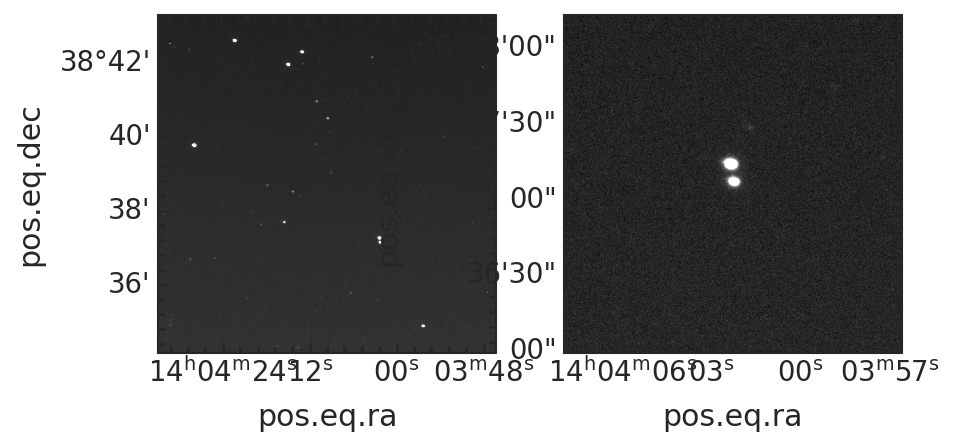

In [10]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy import units as u
import matplotlib.pyplot as pl

from astropy.visualization import ZScaleInterval
interval = ZScaleInterval(contrast=0.1)

fp = "../data/ogg2m001-ep05-20220630-0307-e91.fits"
hdu2 = fits.open(fp)[0]
# zmin, zmax = interval.get_limits(hdu2.data)
# pl.imshow(hdu2.data, origin="lower", vmin=zmin, vmax=zmax, cmap='gray')

def crop_data(hdu2, position, rad_arcsec=300):
    wcs = WCS(hdu2.header)
    coords = wcs.all_world2pix(np.c_[position], 0)
    xpix, ypix = int(coords[0][0]), int(coords[0][1])
    
    pixscale = hdu2.header['PIXSCALE']
    dx = dy = round(rad_arcsec)

    dcrop = hdu2.data[ypix-dy:ypix+dy,xpix-dx:xpix+dx]
    wcscrop = wcs[ypix-dy:ypix+dy,xpix-dx:xpix+dx]
    return dcrop, wcscrop

fig = pl.figure()
ax = fig.add_subplot(121, projection=WCS(hdu2.header))

zmin, zmax = interval.get_limits(hdu2.data)
ax.imshow(hdu2.data, origin="lower", vmin=zmin, vmax=zmax, cmap='gray')


dcrop, wcscrop = crop_data(hdu2, (ra,dec), rad_arcsec=250)
ax = fig.add_subplot(122, projection=wcscrop)
zmin, zmax = interval.get_limits(dcrop)
ax.imshow(dcrop, origin="lower", vmin=zmin, vmax=zmax, cmap='gray')

In [11]:
c2022 = c.apply_space_motion(new_obstime=Time(hdu2.header['DATE-OBS']))
np.sqrt((ra-c2022.ra.deg)**2+(dec-c2022.dec.deg)**2)*60*60

1.3697309443051098

In [12]:
#2022-(2022-1951)//2 = 1986
c1987 = c.apply_space_motion(new_obstime=Time("1987-06-01 00:00"))
c1987

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)
    (211.00940812, 38.61827782, 164.74463296)
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    (-44.64407415, 15.08319952, 0.99989417)>

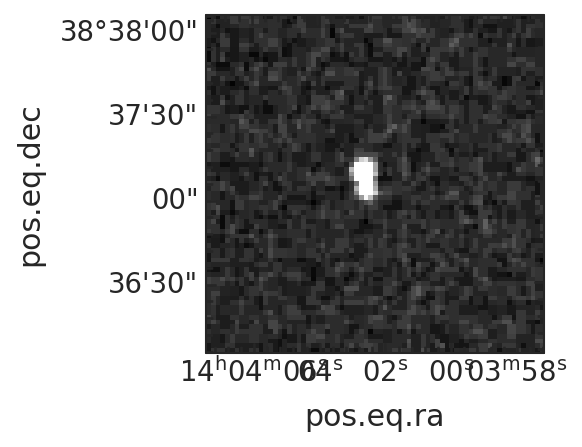

In [13]:
cmap = "gray"
survey="poss1_red"
epoch="J2015.5"
height=2
width=2
base_url = "http://archive.stsci.edu/cgi-bin/dss_search?v="
url = f"{base_url}{survey}&r={c1987.ra.deg}&d={c1987.dec.deg}&e={epoch}&h={height}&w={width}&f=fits&c=none&s=on&fov=NONE&v3"
hdulist = fits.open(url)
hdu1 = hdulist[0]

fig = pl.figure()
ax = fig.add_subplot(121, projection=WCS(hdu1.header))
zmin, zmax = interval.get_limits(hdu1.data)
ax.imshow(hdu1.data, origin="lower", vmin=zmin, vmax=zmax, cmap=cmap)

In [14]:
#time in header is weird: 62mins?
hdu1.header['DATE-OBS']

'1955-04-13T07:38:00'

In [49]:
#update header with a more reasonable time
# hdu1.header['DATE-OBS'] = '1951-07-12T10:02:00.00'

In [16]:
c1955 = c.apply_space_motion(new_obstime=Time(hdu1.header['DATE-OBS']))
np.sqrt((ra-c1955.ra.deg)**2+(dec-c1955.dec.deg)**2)*60*60

2.6026524571965184

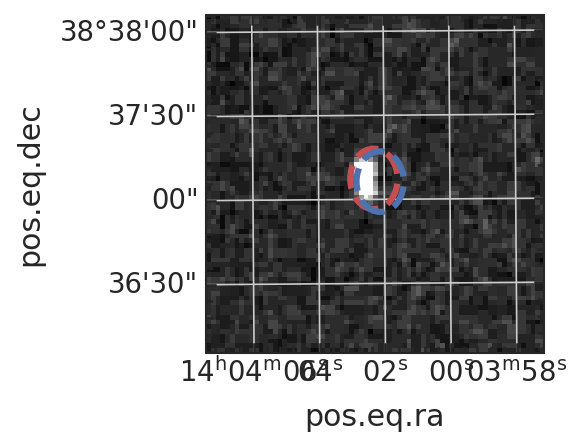

In [17]:
from matplotlib.patches import Circle

fig = pl.figure()
ax = fig.add_subplot(121, projection=WCS(hdu1.header))
zmin, zmax = interval.get_limits(hdu1.data)
ax.imshow(hdu1.data, origin="lower", vmin=zmin, vmax=zmax, cmap=cmap)

dr,dd = -1/3600, 2/3600
c1 = Circle((c1955.ra.deg+dr, c1955.dec.deg+dd), 
            0.003, edgecolor='r', facecolor='none',
            lw=3, transform=ax.get_transform('fk5'), ls='--')
ax.add_patch(c1);
c2 = Circle((c2022.ra.deg, c2022.dec.deg), 
            0.003, edgecolor='b', facecolor='none',
            lw=3, transform=ax.get_transform('fk5'), ls='--')
ax.add_patch(c2);
ax.grid(True)

Set OBSGEO-B to    20.706900 from OBSGEO-[XYZ].
Set OBSGEO-H to     3047.597 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


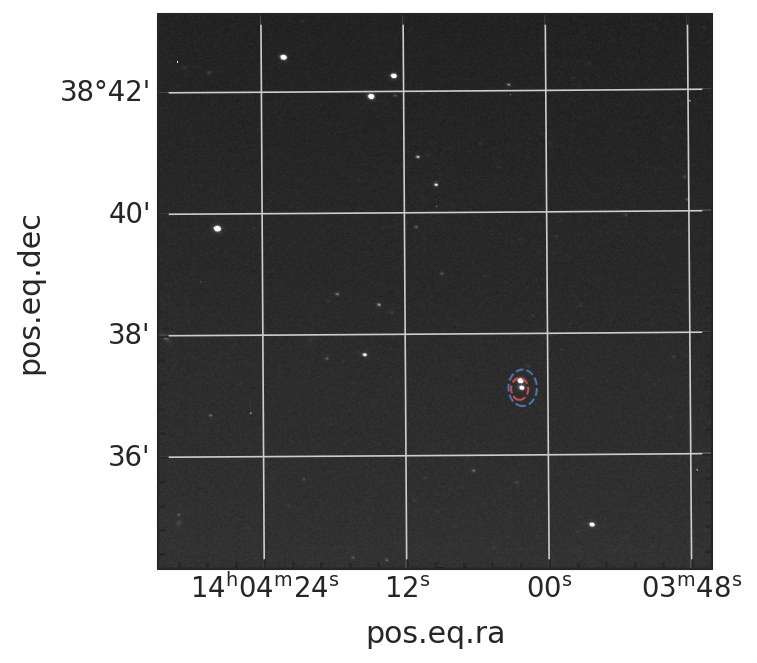

In [18]:
fig = pl.figure()

ax = fig.add_subplot(projection=WCS(hdu2.header))

zmin, zmax = interval.get_limits(hdu2.data)
ax.imshow(hdu2.data, origin="lower", vmin=zmin, vmax=zmax, cmap='gray')

c1 = Circle((c1955.ra.deg, c1955.dec.deg), 
            0.003, edgecolor='r', facecolor='none',
            lw=1, transform=ax.get_transform('fk5'), ls='--')
ax.add_patch(c1);
c2 = Circle((c2022.ra.deg, c2022.dec.deg), 
            0.005, edgecolor='b', facecolor='none',
            lw=1, transform=ax.get_transform('fk5'), ls='--')
ax.add_patch(c2);
ax.grid(True)

Set OBSGEO-B to    20.706900 from OBSGEO-[XYZ].
Set OBSGEO-H to     3047.597 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


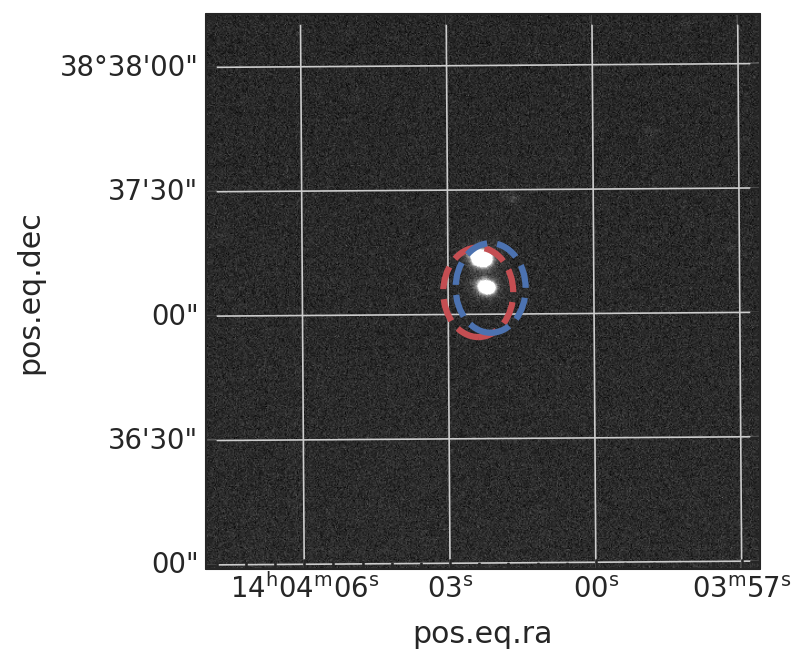

In [20]:
fig = pl.figure()

dcrop, wcscrop = crop_data(hdu2, (c1987.ra.deg, c1987.dec.deg), rad_arcsec=250)
ax = fig.add_subplot(projection=wcscrop)

zmin, zmax = interval.get_limits(dcrop)
ax.imshow(dcrop, origin="lower", vmin=zmin, vmax=zmax, cmap='gray')

c1 = Circle((c1955.ra.deg, c1955.dec.deg), 
            0.003, edgecolor='r', facecolor='none',
            lw=3, transform=ax.get_transform('fk5'), ls='--')
ax.add_patch(c1);
c2 = Circle((c2022.ra.deg, c2022.dec.deg), 
            0.003, edgecolor='b', facecolor='none',
            lw=3, transform=ax.get_transform('fk5'), ls='--')
ax.add_patch(c2);
ax.grid(True)

In [22]:
1954+(2022-1954)/2

1988.0

Set OBSGEO-B to    20.706900 from OBSGEO-[XYZ].
Set OBSGEO-H to     3047.597 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


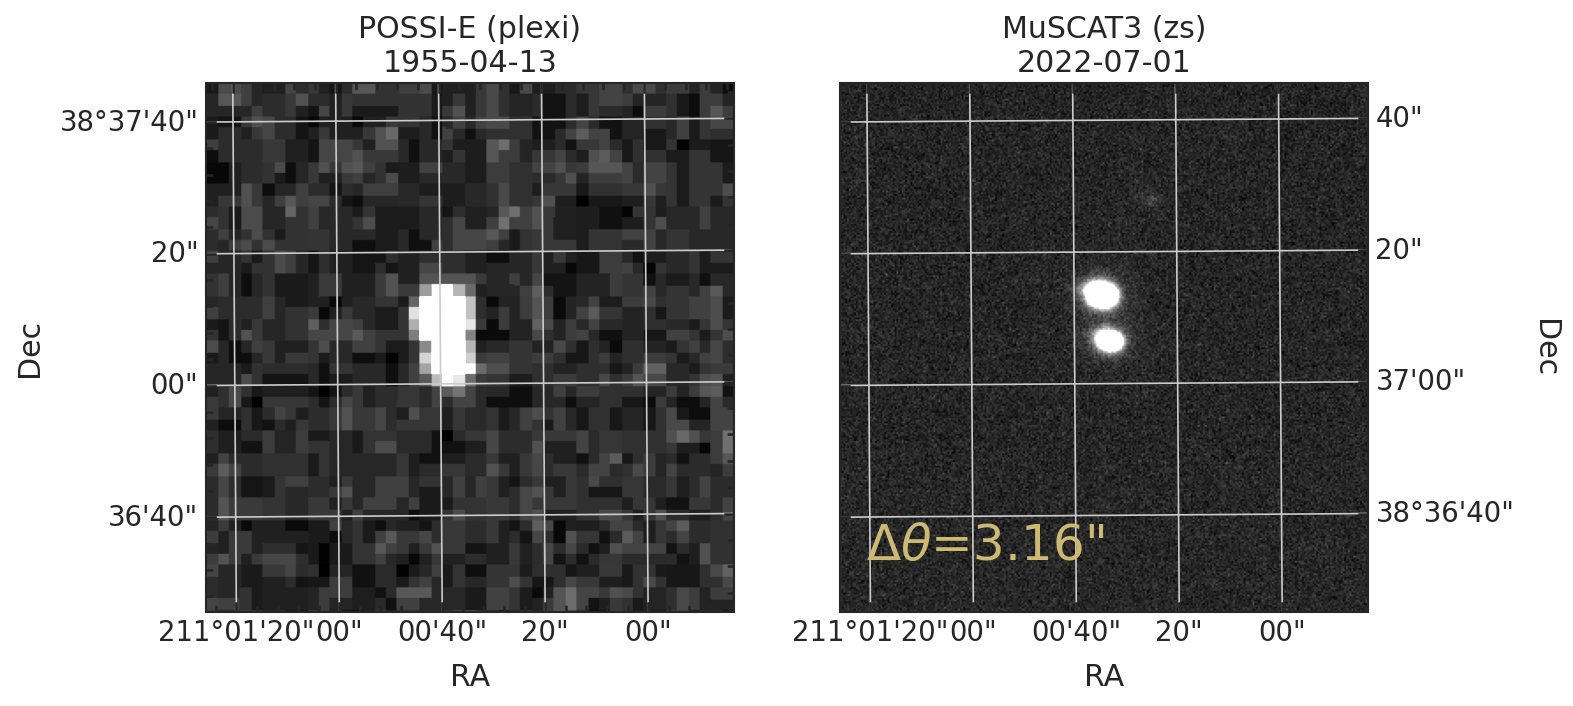

In [29]:
from reproject import reproject_interp, reproject_adaptive
from astropy.visualization import ZScaleInterval
from astropy.nddata.utils import Cutout2D
from astropy.wcs import WCS
from astropy.io import fits
import matplotlib.pyplot as pl
from matplotlib.patches import Circle, FancyArrowPatch

interval = ZScaleInterval(contrast=0.1)

cmap = "gray"
survey="poss1_red"
epoch="J2015.5"
height=2.5 #arcmin
width=2.5
base_url = "http://archive.stsci.edu/cgi-bin/dss_search?v="
url = f"{base_url}{survey}&r={c1987.ra.deg}&d={c1987.dec.deg}&e={epoch}&h={height}&w={width}&f=fits&c=none&s=on&fov=NONE&v3"
hdulist = fits.open(url)
hdu1 = hdulist[0]

#update header
# hdu1.header['DATE-OBS'] = '1951-07-12T10:02:00.00'

fp = "../data/ogg2m001-ep05-20220630-0307-e91.fits"
hdu2 = fits.open(fp)[0]

dcrop, wcscrop = crop_data(hdu2, (c1987.ra.deg, c1987.dec.deg), rad_arcsec=height*60)

projected_img, footprint = reproject_interp(hdu1, 
                                            wcscrop, 
                                            order='nearest-neighbor',
                                           )

fig = pl.figure(figsize=(10, 5), constrained_layout=False)

ax = fig.add_subplot(121, projection=wcscrop)
zmin, zmax = interval.get_limits(projected_img)
ax.imshow(projected_img, origin="lower", vmin=zmin, vmax=zmax, cmap=cmap)

crad = 0.0015
dd = 1/3600
c1 = Circle((c1955.ra.deg, c1955.dec.deg+dd), 
            crad, edgecolor='r', facecolor='none',
            lw=3, transform=ax.get_transform('fk5'), ls='--')
# ax.add_patch(c1);
c2 = Circle((c2022.ra.deg, c2022.dec.deg+dd), 
            crad, edgecolor='b', facecolor='none',
            lw=3, transform=ax.get_transform('fk5'), ls='--')
# ax.add_patch(c2);
ax.grid(True)


coord_format="dd:mm:ss"
ax.coords[1].set_major_formatter(coord_format)
ax.coords[0].set_major_formatter(coord_format)
ax.set_ylabel("Dec")
ax.set_xlabel("RA")

filt1 = (
        hdu1.header["FILTER"]
        if hdu1.header["FILTER"] is not None
        else survey1.split("_")[1]
    )
title = f"{hdu1.header['SURVEY']} ({filt1})\n"
title += f"{hdu1.header['DATE-OBS'][:10]}"
ax.set_title(title)

ax = fig.add_subplot(122, projection=wcscrop)

zmin, zmax = interval.get_limits(dcrop)
ax.imshow(dcrop, origin="lower", vmin=zmin, vmax=zmax, cmap='gray')

c1 = Circle((c1955.ra.deg, c1955.dec.deg), 
            crad, edgecolor='r', facecolor='none',
            lw=3, transform=ax.get_transform('fk5'), ls='--')
# ax.add_patch(c1);
c2 = Circle((c2022.ra.deg, c2022.dec.deg), 
            crad, edgecolor='b', facecolor='none',
            lw=3, transform=ax.get_transform('fk5'), ls='--')
# ax.add_patch(c2);
ax.grid(True)

ax.coords[1].set_major_formatter(coord_format)
ax.coords[0].set_major_formatter(coord_format)
ax.coords["dec"].set_axislabel_position("r")
ax.coords["dec"].set_ticklabel_position("r")
ax.coords["dec"].set_axislabel("Dec")
ax.set_xlabel("RA")

filt2 = hdu2.header
title = f"MuSCAT3 ({hdu2.header['FILTER1']})\n"
title += f"{hdu2.header['DATE-OBS'][:10]}"
ax.set_title(title)

color = 'y'
baseline = int(hdu2.header["DATE-OBS"][:4]) - int(hdu1.header["DATE-OBS"][:4])
pm = np.hypot(pmra, pmdec) #mas/yr
offset = (pm*baseline*u.yr).to(u.arcsec)
text = r"$\Delta \theta$="+f"{offset.value:.2f}\""
ax.text(0.05, 0.1, text, transform=ax.transAxes, c=color, fontsize=24);

add_arrow = False
ax = fig.axes[0]
if add_arrow:
    x_tail = c1955.ra.deg
    y_tail = c1955.dec.deg
    x_head = c2022.ra.deg+dr
    y_head = c2022.dec.deg+dd
    dx = x_head - x_tail
    dy = y_head - y_tail

    offset = -10/3600
    a = FancyArrowPatch((x_tail+offset/2, y_tail+offset), 
                        (x_head-offset/3, y_head-offset/2),
                        mutation_scale=40,
                        edgecolor=color, 
                        facecolor='None', 
                        lw=2, 
                        arrowstyle='simple',
                        transform=ax.get_transform('fk5')
                       )
    ax.add_patch(a);


In [30]:
outpath="../data/archival_imaging.png"
savefig(fig, outpath, dpi=400, writepdf=False)

2024-02-26T07:36:34.456606: made ../data/archival_imaging.png


In [31]:
(pm*baseline*u.yr).to(u.arcsec)

<Quantity 3.15725411 arcsec>